In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Model Setup

In [ ]:
!git clone https://github.com/NathanUA/U-2-Net.git

Cloning into 'U-2-Net'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (422/422), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1077 (delta 398), reused 380 (delta 380), pack-reused 655 (from 2)
Receiving objects: 100% (1077/1077), 66.95 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (536/536), done.


In [2]:
import os, sys
REPO = "/home/deepaksr/project/Project_files_2/U-2-Net"    
os.chdir(REPO)
sys.path.insert(0, REPO)

## Imports

In [3]:
from model import U2NET, U2NETP

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import pandas as pd

## Data loading

In [5]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transform   = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")
        msk = Image.open(self.mask_paths[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
            msk = self.transform(msk)
        return img, msk

In [6]:
def get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.8,0.1,0.1),
    batch_sizes=(64,16,16),
    random_state=42
):
    # collect
    img_files, msk_files = [], []
    for d_img, d_msk in zip(image_dirs, mask_dirs):
        imgs = sorted([os.path.join(d_img,f) for f in os.listdir(d_img)
                    if f.lower().endswith(('.jpg','.png'))])
        msks = sorted([os.path.join(d_msk,f) for f in os.listdir(d_msk)
                    if f.lower().endswith(('.jpg','.png'))])
        assert len(imgs)==len(msks), f"Mismatch in {d_img}"
        img_files.extend(imgs); msk_files.extend(msks)

    # splits
    tr, va, te = split_ratio
    train_imgs, tmp_imgs, train_msks, tmp_msks = train_test_split(
        img_files, msk_files, test_size=(1-tr), random_state=random_state)
    val_prop = va/(va+te)
    val_imgs, test_imgs, val_msks, test_msks = train_test_split(
        tmp_imgs, tmp_msks, test_size=(1-val_prop), random_state=random_state)

    print(f"Total: {len(img_files)} | Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    # transforms
    tfm = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor()
    ])

    dl = lambda imgs, msks, bs, shuffle: DataLoader(
        SaliencyDataset(imgs, msks, tfm),
        batch_size=bs, shuffle=shuffle
    )

    return (
        dl(train_imgs, train_msks, batch_sizes[0], True),
        dl(val_imgs,   val_msks,   batch_sizes[1], False),
        dl(test_imgs,  test_msks,  batch_sizes[2], False)
    )

## Training Setup

In [7]:
bce_loss = nn.BCELoss()
def multi_bce_loss_fusion(d0,d1,d2,d3,d4,d5,d6,labels):
    losses = [bce_loss(d,labels) for d in (d0,d1,d2,d3,d4,d5,d6)]
    return losses[0], sum(losses)

def train_model(model, train_loader, val_loader,
                optimizer,
                scheduler=None,
                num_epochs=25,
                log_prefix="u2net_finetune",
                device="cuda"):
    ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"./training_logs/{log_prefix}_{ts}"
    os.makedirs(log_dir, exist_ok=True)
    best_loss = float('inf'); best_path=None
    train_losses, val_losses, lrs = [],[],[]

    for epoch in range(num_epochs):
        model.train(); t_loss=0
        for imgs, msks in train_loader:
            imgs,msks = imgs.to(device),msks.to(device)
            optimizer.zero_grad()
            outs = model(imgs)
            l0, loss = multi_bce_loss_fusion(*outs, msks)
            loss.backward(); optimizer.step()
            t_loss += loss.item()
        train_losses.append(t_loss/len(train_loader))

        # val
        model.eval(); v_loss=0
        with torch.no_grad():
            for imgs, msks in val_loader:
                imgs,msks = imgs.to(device),msks.to(device)
                outs = model(imgs)
                _, loss = multi_bce_loss_fusion(*outs, msks)
                v_loss += loss.item()
        val_losses.append(v_loss/len(val_loader))

        lr = optimizer.param_groups[0]['lr']; lrs.append(lr)
        if scheduler: scheduler.step(val_losses[-1])
        print(f"[{epoch+1}/{num_epochs}] LR:{lr:.1e} Train:{train_losses[-1]:.4f} Val:{val_losses[-1]:.4f}")

        if val_losses[-1] < best_loss:
            best_loss = val_losses[-1]
            best_path = os.path.join(log_dir,"best_model.pth")
            torch.save(model.state_dict(), best_path)
            print(f"Saved best model: {best_path}")

    # plot & csv
    plt.plot(train_losses,label="Train"); plt.plot(val_losses,label="Val")
    plt.legend(); plt.title("Loss Curve"); plt.grid(True)
    plt.savefig(os.path.join(log_dir,"loss.png")); plt.show()

    df = pd.DataFrame({
        "epoch": list(range(1,num_epochs+1)),
        "train_loss": train_losses,
        "val_loss": val_losses,
        "lr": lrs
    })
    df.to_csv(os.path.join(log_dir,"loss_log.csv"),index=False)
    print(f"Logs saved to {log_dir}")
    return best_path


## Evaluation Setup

In [8]:
def compute_min_pixel_fraction(dataloader, bin_thresh=0.5):
    min_frac = float('inf')
    for _, masks in dataloader:
        m = masks.numpy()  # (B,1,H,W)
        for slice in m:
            binary = (slice[0] >= bin_thresh).astype(np.uint8)
            frac = binary.sum() / binary.size
            if 0 < frac < min_frac:
                min_frac = frac
    return min_frac if min_frac < float('inf') else 0.0

def evaluate_model(
    model, dataloader, device,
    bin_thresh=0.5, area_frac=0.001,
    compute_area_frac=False, beta2=0.3,
    visualize=False, save_folder=None
):
    model.eval()
    if compute_area_frac:
        area_frac = compute_min_pixel_fraction(dataloader, bin_thresh)
        print(f"[INFO] Computed area_frac={area_frac:.6f}")

    mae_sum = prec_sum = rec_sum = 0
    iou_list = []
    y_true = []
    y_pred = []
    n = 0

    # create save folder
    if save_folder:
        os.makedirs(save_folder, exist_ok=True)

    with torch.no_grad():
        for batch_idx, (imgs, msks) in enumerate(dataloader):
            imgs, msks = imgs.to(device), msks.to(device)
            outs = model(imgs)            # tuple of 7 outputs
            d0 = outs[0]                  # first side-output
            # normalize per-sample
            d0 = (d0 - d0.min()) / (d0.max() - d0.min() + 1e-8)
            preds = d0.cpu().numpy()      # shape (B,1,H,W)
            gts   = msks.cpu().numpy()

            for i in range(preds.shape[0]):
                pred = preds[i,0]
                gt   = gts[i,0]

                # save mask if requested
                if save_folder:
                    import numpy as _np
                    from PIL import Image as _Image
                    mask_img = (_np.clip(pred,0,1) * 255).astype(_np.uint8)
                    fname = os.path.basename(dataloader.dataset.image_paths[batch_idx * dataloader.batch_size + i])
                    _Image.fromarray(mask_img).save(os.path.join(save_folder, fname))

                # MAE
                mae_sum += np.mean(np.abs(pred - gt))

                # Binarize
                pbin = (pred >= bin_thresh).astype(int).ravel()
                gbin = (gt   >= bin_thresh).astype(int).ravel()

                tp = (pbin & gbin).sum()
                fp = (pbin & (1-gbin)).sum()
                fn = ((1-pbin) & gbin).sum()

                prec = tp / (tp + fp + 1e-8)
                rec  = tp / (tp + fn + 1e-8)
                prec_sum += prec
                rec_sum  += rec

                iou_list.append(tp / (tp + fp + fn + 1e-8))

                # presence
                has_gt   = (gbin.sum() / gbin.size) > area_frac
                has_pred = (pbin.sum() / pbin.size) > area_frac
                y_true.append(has_gt)
                y_pred.append(has_pred)

                n += 1

    # aggregate
    mae   = mae_sum / n
    prec  = prec_sum / n
    rec   = rec_sum / n
    fbeta = (1 + beta2) * prec * rec / (beta2 * prec + rec + 1e-8)
    miou  = np.mean(iou_list)
    tp_obj = sum(t and p for t, p in zip(y_true, y_pred))
    fn_obj = sum(t and not p for t, p in zip(y_true, y_pred))
    obj_rec = tp_obj / (tp_obj + fn_obj + 1e-8)

    print("\n=== Evaluation Results ===")
    print(f"MAE            : {mae:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"Fβ (β²={beta2}): {fbeta:.4f}")
    print(f"Mean IoU       : {miou:.4f}")
    print(f"Obj Presence R : {obj_rec:.4f}")
    print(f"Binarize thres.: {bin_thresh:.2f}")
    print(f"Area fraction  : {area_frac:.6f}")

    if visualize:
        # show last batch’s first sample
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        sample_img = imgs[0].cpu().permute(1, 2, 0)
        axs[0].imshow(sample_img);     axs[0].set_title("Image")
        axs[1].imshow(gts[0,0],cmap='gray'); axs[1].set_title("GT Mask")
        axs[2].imshow(preds[0,0],cmap='gray');axs[2].set_title("Pred Mask")
        plt.show()

    return {
        "mae": mae,
        "precision": prec,
        "recall": rec,
        "f_beta": fbeta,
        "miou": miou,
        "obj_recall": obj_rec,
        "bin_thresh": bin_thresh,
        "area_frac": area_frac
    }


## Direct inference on Pre-Trained model

### Load model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "u2netp"

# 1) Instantiate a 1‐channel model
model_1ch = U2NETP(1, 1).to(device)

# 2) Load original 3‐channel checkpoint
orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",
                        map_location=device)

# 3) Build a new state dict
new_state = {}
for name, param in orig_state.items():
    # target shape in the 1ch model (if it exists)
    if name in model_1ch.state_dict():
        tgt = model_1ch.state_dict()[name]
        # mismatch only in the in_channels dimension?
        if param.shape != tgt.shape:
            # param is weight with shape [out_c, in_c=3, k, k]
            # tgt is [out_c, in_c=1, k, k]
            if len(param.shape) == 4 and param.shape[1] == 3 and tgt.shape[1] == 1:
                # average across the original in_channels dim
                averaged = param.mean(dim=1, keepdim=True)
                new_state[name] = averaged
                print(f"Averaged '{name}' from {param.shape} → {averaged.shape}")
            else:
                # unexpected mismatch—skip or you can raise
                print(f"Skipping '{name}' due to unexpected shape {param.shape} → {tgt.shape}")
        else:
            # shapes match exactly—copy over
            new_state[name] = param
    else:
        # parameter not used by new model (unlikely)
        print(f"Parameter '{name}' not found in new model—skipping")

# 4) Load into model (strict=False so any missing keys are ignored)
model_1ch.load_state_dict(new_state, strict=False)
model_1ch.eval()

# 5) Check summary
from torchsummary import summary
print("Single‐channel U2NETP summary:")
summary(model_1ch, input_size=(1, 320, 320), device=str(device))


/tmp/ipykernel_1200328/1906240996.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",


Averaged 'stage1.rebnconvin.conv_s1.weight' from torch.Size([64, 3, 3, 3]) → torch.Size([64, 1, 3, 3])
Single‐channel U2NETP summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]             640
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1,

/home/deepaksr/project/Project_files_2/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


### 1 - Simulated IR dataset

In [10]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/norm_ir_8bit"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

Total: 2751 | Train: 1925, Val: 413, Test: 413

=== Evaluation Results ===
MAE            : 0.0560
Precision      : 0.1051
Recall         : 0.0028
Fβ (β²=0.3): 0.0112
Mean IoU       : 0.0028
Obj Presence R : 0.0479
Binarize thres.: 0.50
Area fraction  : 0.001000


### 2 - Military paper IR dataset

In [11]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/IR_norm8bit"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/IR"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

Total: 2100 | Train: 1469, Val: 315, Test: 316

=== Evaluation Results ===
MAE            : 0.0858
Precision      : 0.0712
Recall         : 0.0900
Fβ (β²=0.3): 0.0748
Mean IoU       : 0.0333
Obj Presence R : 0.2943
Binarize thres.: 0.50
Area fraction  : 0.001000


### 3 - IR military scenario dataset

In [12]:
# adjust your paths here:
image_dirs = [
r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/images"
]
mask_dirs  = [
r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/saliency_masks"
]
train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

# specify a folder if you want to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5
)

# save metrics to CSV
pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)

Total: 21972 | Train: 15380, Val: 3296, Test: 3296

=== Evaluation Results ===
MAE            : 0.0241
Precision      : 0.2212
Recall         : 0.0592
Fβ (β²=0.3): 0.1356
Mean IoU       : 0.0469
Obj Presence R : 0.2908
Binarize thres.: 0.50
Area fraction  : 0.001000


###  4 - IR Bridge dataset

In [13]:
# adjust your paths here:
image_dirs = [
r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/images"
]
mask_dirs  = [
r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

# specify a folder if you want to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5
)

# save metrics to CSV
pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)

Total: 1877 | Train: 1313, Val: 282, Test: 282

=== Evaluation Results ===
MAE            : 0.1111
Precision      : 0.0647
Recall         : 0.0006
Fβ (β²=0.3): 0.0026
Mean IoU       : 0.0006
Obj Presence R : 0.1206
Binarize thres.: 0.50
Area fraction  : 0.001000


###  5 - IR HIT-UAV dataset

In [14]:
# adjust your paths here:
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/val"
]
mask_dirs  = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/val" 
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

# specify a folder if you want to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5
)

# save metrics to CSV
pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)

Total: 2866 | Train: 2006, Val: 430, Test: 430

=== Evaluation Results ===
MAE            : 0.0554
Precision      : 0.0757
Recall         : 0.0449
Fβ (β²=0.3): 0.0653
Mean IoU       : 0.0166
Obj Presence R : 0.1825
Binarize thres.: 0.50
Area fraction  : 0.001000


###  6 - IR combined dataset

In [15]:
# adjust your paths here:
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/val",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/images",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/images",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/IR_norm8bit",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/norm_ir_8bit"
]
mask_dirs  = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/val",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/IR",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

# specify a folder if you want to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5
)

# save metrics to CSV
pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)

Total: 31566 | Train: 22096, Val: 4735, Test: 4735

=== Evaluation Results ===
MAE            : 0.0361
Precision      : 0.1769
Recall         : 0.0523
Fβ (β²=0.3): 0.1141
Mean IoU       : 0.0365
Obj Presence R : 0.2505
Binarize thres.: 0.50
Area fraction  : 0.001000


## Finetune Pre-Trained model and Evaluate

### 1 - Simulated IR dataset

#### Load model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "u2netp"

# 1) Instantiate a 1‐channel model
model_1ch = U2NETP(1, 1).to(device)

# 2) Load original 3‐channel checkpoint
orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",
                        map_location=device)

# 3) Build a new state dict
new_state = {}
for name, param in orig_state.items():
    # target shape in the 1ch model (if it exists)
    if name in model_1ch.state_dict():
        tgt = model_1ch.state_dict()[name]
        # mismatch only in the in_channels dimension?
        if param.shape != tgt.shape:
            # param is weight with shape [out_c, in_c=3, k, k]
            # tgt is [out_c, in_c=1, k, k]
            if len(param.shape) == 4 and param.shape[1] == 3 and tgt.shape[1] == 1:
                # average across the original in_channels dim
                averaged = param.mean(dim=1, keepdim=True)
                new_state[name] = averaged
                print(f"Averaged '{name}' from {param.shape} → {averaged.shape}")
            else:
                # unexpected mismatch—skip or you can raise
                print(f"Skipping '{name}' due to unexpected shape {param.shape} → {tgt.shape}")
        else:
            # shapes match exactly—copy over
            new_state[name] = param
    else:
        # parameter not used by new model (unlikely)
        print(f"Parameter '{name}' not found in new model—skipping")

# 4) Load into model (strict=False so any missing keys are ignored)
model_1ch.load_state_dict(new_state, strict=False)
model_1ch.eval()

# 5) Check summary
from torchsummary import summary
print("Single‐channel U2NETP summary:")
summary(model_1ch, input_size=(1, 320, 320), device=str(device))


/tmp/ipykernel_1200328/1906240996.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",


Averaged 'stage1.rebnconvin.conv_s1.weight' from torch.Size([64, 3, 3, 3]) → torch.Size([64, 1, 3, 3])
Single‐channel U2NETP summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]             640
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1,

#### Finetune

Total: 2751 | Train: 1925, Val: 413, Test: 413
[1/20] LR:1.0e-04 Train:12.7093 Val:7.1633
Saved best model: ./training_logs/u2netp_finetune_ir_d1_20250511_201145/best_model.pth
[2/20] LR:1.0e-04 Train:4.9252 Val:3.0782
Saved best model: ./training_logs/u2netp_finetune_ir_d1_20250511_201145/best_model.pth
[3/20] LR:1.0e-04 Train:2.3894 Val:1.9663
Saved best model: ./training_logs/u2netp_finetune_ir_d1_20250511_201145/best_model.pth
[4/20] LR:1.0e-04 Train:1.4212 Val:1.3471
Saved best model: ./training_logs/u2netp_finetune_ir_d1_20250511_201145/best_model.pth
[5/20] LR:1.0e-04 Train:1.0662 Val:1.0991
Saved best model: ./training_logs/u2netp_finetune_ir_d1_20250511_201145/best_model.pth
[6/20] LR:1.0e-04 Train:0.8820 Val:0.7416
Saved best model: ./training_logs/u2netp_finetune_ir_d1_20250511_201145/best_model.pth
[7/20] LR:1.0e-04 Train:0.7856 Val:0.6410
Saved best model: ./training_logs/u2netp_finetune_ir_d1_20250511_201145/best_model.pth
[8/20] LR:1.0e-04 Train:0.7173 Val:0.6094
Saved b

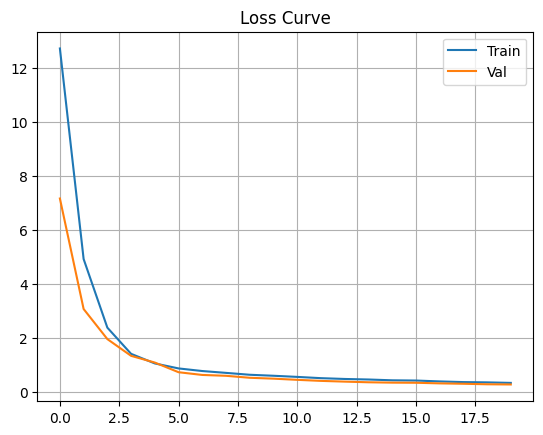

Logs saved to ./training_logs/u2netp_finetune_ir_d1_20250511_201145
Best checkpoint: ./training_logs/u2netp_finetune_ir_d1_20250511_201145/best_model.pth


In [17]:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/norm_ir_8bit"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(16,8,8)
)

optimizer = optim.Adam(model_1ch.parameters(), lr=1e-4)
best_ckpt = train_model(
    model_1ch, train_loader, val_loader,
    optimizer,
    scheduler=None,
    num_epochs=20,
    log_prefix="u2netp_finetune_ir_d1",
    device=device
)

print("Best checkpoint:", best_ckpt)


#### Evaluate

In [18]:
# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)


=== Evaluation Results ===
MAE            : 0.0161
Precision      : 0.7397
Recall         : 0.5989
Fβ (β²=0.3): 0.7016
Mean IoU       : 0.5276
Obj Presence R : 0.9069
Binarize thres.: 0.50
Area fraction  : 0.001000


### 2 - Military paper IR dataset

#### Load model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "u2netp"

# 1) Instantiate a 1‐channel model
model_1ch = U2NETP(1, 1).to(device)

# 2) Load original 3‐channel checkpoint
orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",
                        map_location=device)

# 3) Build a new state dict
new_state = {}
for name, param in orig_state.items():
    # target shape in the 1ch model (if it exists)
    if name in model_1ch.state_dict():
        tgt = model_1ch.state_dict()[name]
        # mismatch only in the in_channels dimension?
        if param.shape != tgt.shape:
            # param is weight with shape [out_c, in_c=3, k, k]
            # tgt is [out_c, in_c=1, k, k]
            if len(param.shape) == 4 and param.shape[1] == 3 and tgt.shape[1] == 1:
                # average across the original in_channels dim
                averaged = param.mean(dim=1, keepdim=True)
                new_state[name] = averaged
                print(f"Averaged '{name}' from {param.shape} → {averaged.shape}")
            else:
                # unexpected mismatch—skip or you can raise
                print(f"Skipping '{name}' due to unexpected shape {param.shape} → {tgt.shape}")
        else:
            # shapes match exactly—copy over
            new_state[name] = param
    else:
        # parameter not used by new model (unlikely)
        print(f"Parameter '{name}' not found in new model—skipping")

# 4) Load into model (strict=False so any missing keys are ignored)
model_1ch.load_state_dict(new_state, strict=False)
model_1ch.eval()

# 5) Check summary
from torchsummary import summary
print("Single‐channel U2NETP summary:")
summary(model_1ch, input_size=(1, 320, 320), device=str(device))


/tmp/ipykernel_1200328/1906240996.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",


Averaged 'stage1.rebnconvin.conv_s1.weight' from torch.Size([64, 3, 3, 3]) → torch.Size([64, 1, 3, 3])
Single‐channel U2NETP summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]             640
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1,

#### Finetune

Total: 2100 | Train: 1469, Val: 315, Test: 316
[1/20] LR:1.0e-04 Train:16.7979 Val:11.7286
Saved best model: ./training_logs/u2netp_finetune_ir_d2_20250511_210042/best_model.pth
[2/20] LR:1.0e-04 Train:9.3845 Val:7.2471
Saved best model: ./training_logs/u2netp_finetune_ir_d2_20250511_210042/best_model.pth
[3/20] LR:1.0e-04 Train:5.1925 Val:4.5636
Saved best model: ./training_logs/u2netp_finetune_ir_d2_20250511_210042/best_model.pth
[4/20] LR:1.0e-04 Train:3.0536 Val:2.5720
Saved best model: ./training_logs/u2netp_finetune_ir_d2_20250511_210042/best_model.pth
[5/20] LR:1.0e-04 Train:2.2606 Val:2.0040
Saved best model: ./training_logs/u2netp_finetune_ir_d2_20250511_210042/best_model.pth
[6/20] LR:1.0e-04 Train:1.9491 Val:1.7450
Saved best model: ./training_logs/u2netp_finetune_ir_d2_20250511_210042/best_model.pth
[7/20] LR:1.0e-04 Train:1.7782 Val:1.6064
Saved best model: ./training_logs/u2netp_finetune_ir_d2_20250511_210042/best_model.pth
[8/20] LR:1.0e-04 Train:1.6449 Val:1.5348
Saved 

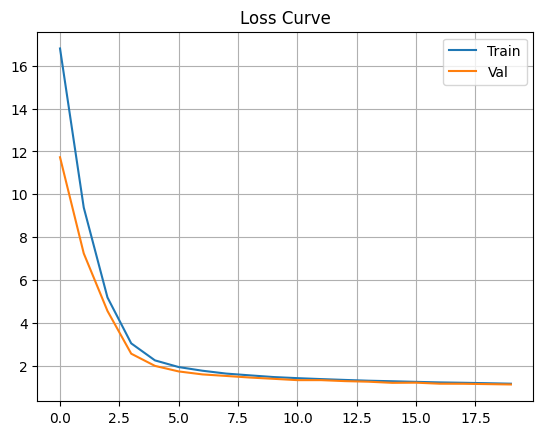

Logs saved to ./training_logs/u2netp_finetune_ir_d2_20250511_210042
Best checkpoint: ./training_logs/u2netp_finetune_ir_d2_20250511_210042/best_model.pth


In [20]:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/IR_norm8bit"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/IR"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(16,8,8)
)

optimizer = optim.Adam(model_1ch.parameters(), lr=1e-4)
best_ckpt = train_model(
    model_1ch, train_loader, val_loader,
    optimizer,
    scheduler=None,
    num_epochs=20,
    log_prefix="u2netp_finetune_ir_d2",
    device=device
)

print("Best checkpoint:", best_ckpt)


#### Evaluate

In [21]:
# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)


=== Evaluation Results ===
MAE            : 0.0760
Precision      : 0.4302
Recall         : 0.1251
Fβ (β²=0.3): 0.2753
Mean IoU       : 0.1069
Obj Presence R : 0.8165
Binarize thres.: 0.50
Area fraction  : 0.001000


### 3 - IR military scenario dataset

#### Load model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "u2netp"

# 1) Instantiate a 1‐channel model
model_1ch = U2NETP(1, 1).to(device)

# 2) Load original 3‐channel checkpoint
orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",
                        map_location=device)

# 3) Build a new state dict
new_state = {}
for name, param in orig_state.items():
    # target shape in the 1ch model (if it exists)
    if name in model_1ch.state_dict():
        tgt = model_1ch.state_dict()[name]
        # mismatch only in the in_channels dimension?
        if param.shape != tgt.shape:
            # param is weight with shape [out_c, in_c=3, k, k]
            # tgt is [out_c, in_c=1, k, k]
            if len(param.shape) == 4 and param.shape[1] == 3 and tgt.shape[1] == 1:
                # average across the original in_channels dim
                averaged = param.mean(dim=1, keepdim=True)
                new_state[name] = averaged
                print(f"Averaged '{name}' from {param.shape} → {averaged.shape}")
            else:
                # unexpected mismatch—skip or you can raise
                print(f"Skipping '{name}' due to unexpected shape {param.shape} → {tgt.shape}")
        else:
            # shapes match exactly—copy over
            new_state[name] = param
    else:
        # parameter not used by new model (unlikely)
        print(f"Parameter '{name}' not found in new model—skipping")

# 4) Load into model (strict=False so any missing keys are ignored)
model_1ch.load_state_dict(new_state, strict=False)
model_1ch.eval()

# 5) Check summary
from torchsummary import summary
print("Single‐channel U2NETP summary:")
summary(model_1ch, input_size=(1, 320, 320), device=str(device))


/tmp/ipykernel_1200328/1906240996.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",


Averaged 'stage1.rebnconvin.conv_s1.weight' from torch.Size([64, 3, 3, 3]) → torch.Size([64, 1, 3, 3])
Single‐channel U2NETP summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]             640
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1,

#### Finetune

Total: 21972 | Train: 15380, Val: 3296, Test: 3296
[1/20] LR:1.0e-04 Train:3.4652 Val:0.4477
Saved best model: ./training_logs/u2netp_finetune_ir_d3_20250511_212158/best_model.pth
[2/20] LR:1.0e-04 Train:0.3440 Val:0.2646
Saved best model: ./training_logs/u2netp_finetune_ir_d3_20250511_212158/best_model.pth
[3/20] LR:1.0e-04 Train:0.2418 Val:0.2092
Saved best model: ./training_logs/u2netp_finetune_ir_d3_20250511_212158/best_model.pth
[4/20] LR:1.0e-04 Train:0.1996 Val:0.1821
Saved best model: ./training_logs/u2netp_finetune_ir_d3_20250511_212158/best_model.pth
[5/20] LR:1.0e-04 Train:0.1728 Val:0.1583
Saved best model: ./training_logs/u2netp_finetune_ir_d3_20250511_212158/best_model.pth
[6/20] LR:1.0e-04 Train:0.1544 Val:0.1438
Saved best model: ./training_logs/u2netp_finetune_ir_d3_20250511_212158/best_model.pth
[7/20] LR:1.0e-04 Train:0.1409 Val:0.1326
Saved best model: ./training_logs/u2netp_finetune_ir_d3_20250511_212158/best_model.pth
[8/20] LR:1.0e-04 Train:0.1307 Val:0.1256
Save

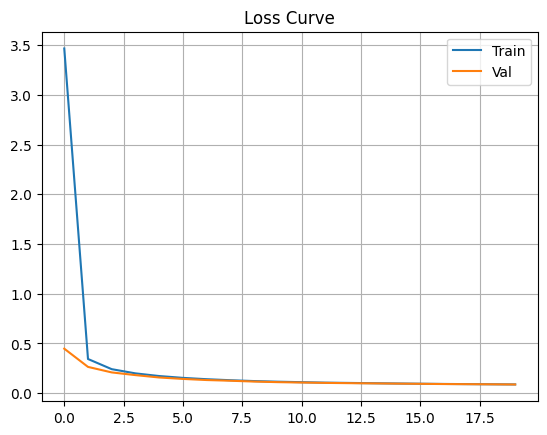

Logs saved to ./training_logs/u2netp_finetune_ir_d3_20250511_212158
Best checkpoint: ./training_logs/u2netp_finetune_ir_d3_20250511_212158/best_model.pth


In [23]:
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/images"
]
mask_dirs  = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(16,8,8)
)

optimizer = optim.Adam(model_1ch.parameters(), lr=1e-4)
best_ckpt = train_model(
    model_1ch, train_loader, val_loader,
    optimizer,
    scheduler=None,
    num_epochs=20,
    log_prefix="u2netp_finetune_ir_d3",
    device=device
)

print("Best checkpoint:", best_ckpt)


#### Evaluate

In [24]:
# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)


=== Evaluation Results ===
MAE            : 0.0046
Precision      : 0.8415
Recall         : 0.8195
Fβ (β²=0.3): 0.8363
Mean IoU       : 0.7631
Obj Presence R : 0.9917
Binarize thres.: 0.50
Area fraction  : 0.001000


###  4 - IR Bridge dataset

#### Load model

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "u2netp"

# 1) Instantiate a 1‐channel model
model_1ch = U2NETP(1, 1).to(device)

# 2) Load original 3‐channel checkpoint
orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",
                        map_location=device)

# 3) Build a new state dict
new_state = {}
for name, param in orig_state.items():
    # target shape in the 1ch model (if it exists)
    if name in model_1ch.state_dict():
        tgt = model_1ch.state_dict()[name]
        # mismatch only in the in_channels dimension?
        if param.shape != tgt.shape:
            # param is weight with shape [out_c, in_c=3, k, k]
            # tgt is [out_c, in_c=1, k, k]
            if len(param.shape) == 4 and param.shape[1] == 3 and tgt.shape[1] == 1:
                # average across the original in_channels dim
                averaged = param.mean(dim=1, keepdim=True)
                new_state[name] = averaged
                print(f"Averaged '{name}' from {param.shape} → {averaged.shape}")
            else:
                # unexpected mismatch—skip or you can raise
                print(f"Skipping '{name}' due to unexpected shape {param.shape} → {tgt.shape}")
        else:
            # shapes match exactly—copy over
            new_state[name] = param
    else:
        # parameter not used by new model (unlikely)
        print(f"Parameter '{name}' not found in new model—skipping")

# 4) Load into model (strict=False so any missing keys are ignored)
model_1ch.load_state_dict(new_state, strict=False)
model_1ch.eval()

# 5) Check summary
from torchsummary import summary
print("Single‐channel U2NETP summary:")
summary(model_1ch, input_size=(1, 320, 320), device=str(device))


Averaged 'stage1.rebnconvin.conv_s1.weight' from torch.Size([64, 3, 3, 3]) → torch.Size([64, 1, 3, 3])


/tmp/ipykernel_1200328/1906240996.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",


Single‐channel U2NETP summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]             640
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1, 16, 160, 160]               0
         REBNCONV-13         [-1, 16, 160, 160]               0
        

#### Finetune

Total: 1877 | Train: 1313, Val: 282, Test: 282
[1/20] LR:1.0e-04 Train:13.5293 Val:6.0909
Saved best model: ./training_logs/u2netp_finetune_ir_d4_20250512_010041/best_model.pth
[2/20] LR:1.0e-04 Train:7.0438 Val:4.6421
Saved best model: ./training_logs/u2netp_finetune_ir_d4_20250512_010041/best_model.pth
[3/20] LR:1.0e-04 Train:4.0174 Val:3.2990
Saved best model: ./training_logs/u2netp_finetune_ir_d4_20250512_010041/best_model.pth
[4/20] LR:1.0e-04 Train:2.7425 Val:2.3173
Saved best model: ./training_logs/u2netp_finetune_ir_d4_20250512_010041/best_model.pth
[5/20] LR:1.0e-04 Train:2.1751 Val:1.9720
Saved best model: ./training_logs/u2netp_finetune_ir_d4_20250512_010041/best_model.pth
[6/20] LR:1.0e-04 Train:1.8940 Val:1.9206
Saved best model: ./training_logs/u2netp_finetune_ir_d4_20250512_010041/best_model.pth
[7/20] LR:1.0e-04 Train:1.7208 Val:1.7039
Saved best model: ./training_logs/u2netp_finetune_ir_d4_20250512_010041/best_model.pth
[8/20] LR:1.0e-04 Train:1.5563 Val:1.6074
Saved b

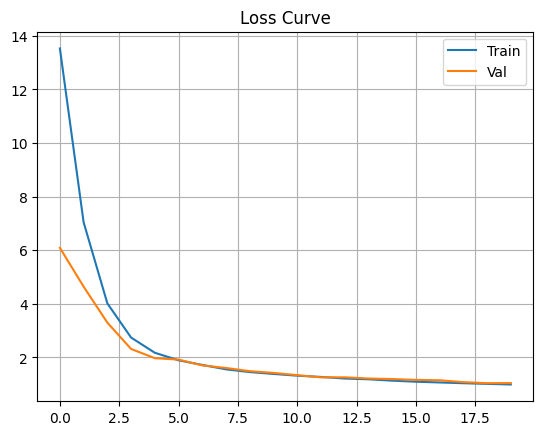

Logs saved to ./training_logs/u2netp_finetune_ir_d4_20250512_010041
Best checkpoint: ./training_logs/u2netp_finetune_ir_d4_20250512_010041/best_model.pth


In [26]:
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/images"
]
mask_dirs  = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(16,8,8)
)

optimizer = optim.Adam(model_1ch.parameters(), lr=1e-4)
best_ckpt = train_model(
    model_1ch, train_loader, val_loader,
    optimizer,
    scheduler=None,
    num_epochs=20,
    log_prefix="u2netp_finetune_ir_d4",
    device=device
)

print("Best checkpoint:", best_ckpt)


#### Evaluate

In [27]:
# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)


=== Evaluation Results ===
MAE            : 0.0633
Precision      : 0.7841
Recall         : 0.6508
Fβ (β²=0.3): 0.7487
Mean IoU       : 0.5448
Obj Presence R : 0.9929
Binarize thres.: 0.50
Area fraction  : 0.001000


###  5 - IR HIT-UAV dataset

#### Load model

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "u2netp"

# 1) Instantiate a 1‐channel model
model_1ch = U2NETP(1, 1).to(device)

# 2) Load original 3‐channel checkpoint
orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",
                        map_location=device)

# 3) Build a new state dict
new_state = {}
for name, param in orig_state.items():
    # target shape in the 1ch model (if it exists)
    if name in model_1ch.state_dict():
        tgt = model_1ch.state_dict()[name]
        # mismatch only in the in_channels dimension?
        if param.shape != tgt.shape:
            # param is weight with shape [out_c, in_c=3, k, k]
            # tgt is [out_c, in_c=1, k, k]
            if len(param.shape) == 4 and param.shape[1] == 3 and tgt.shape[1] == 1:
                # average across the original in_channels dim
                averaged = param.mean(dim=1, keepdim=True)
                new_state[name] = averaged
                print(f"Averaged '{name}' from {param.shape} → {averaged.shape}")
            else:
                # unexpected mismatch—skip or you can raise
                print(f"Skipping '{name}' due to unexpected shape {param.shape} → {tgt.shape}")
        else:
            # shapes match exactly—copy over
            new_state[name] = param
    else:
        # parameter not used by new model (unlikely)
        print(f"Parameter '{name}' not found in new model—skipping")

# 4) Load into model (strict=False so any missing keys are ignored)
model_1ch.load_state_dict(new_state, strict=False)
model_1ch.eval()

# 5) Check summary
from torchsummary import summary
print("Single‐channel U2NETP summary:")
summary(model_1ch, input_size=(1, 320, 320), device=str(device))


Averaged 'stage1.rebnconvin.conv_s1.weight' from torch.Size([64, 3, 3, 3]) → torch.Size([64, 1, 3, 3])


/tmp/ipykernel_1200328/1906240996.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",


Single‐channel U2NETP summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]             640
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1, 16, 160, 160]               0
         REBNCONV-13         [-1, 16, 160, 160]               0
        

#### Finetune

Total: 2866 | Train: 2006, Val: 430, Test: 430
[1/20] LR:1.0e-04 Train:14.7097 Val:9.2842
Saved best model: ./training_logs/u2netp_finetune_ir_d5_20250512_011730/best_model.pth
[2/20] LR:1.0e-04 Train:5.8135 Val:3.9772
Saved best model: ./training_logs/u2netp_finetune_ir_d5_20250512_011730/best_model.pth
[3/20] LR:1.0e-04 Train:2.5019 Val:2.0329
Saved best model: ./training_logs/u2netp_finetune_ir_d5_20250512_011730/best_model.pth
[4/20] LR:1.0e-04 Train:1.5475 Val:1.5756
Saved best model: ./training_logs/u2netp_finetune_ir_d5_20250512_011730/best_model.pth
[5/20] LR:1.0e-04 Train:1.3146 Val:1.2571
Saved best model: ./training_logs/u2netp_finetune_ir_d5_20250512_011730/best_model.pth
[6/20] LR:1.0e-04 Train:1.1933 Val:1.1795
Saved best model: ./training_logs/u2netp_finetune_ir_d5_20250512_011730/best_model.pth
[7/20] LR:1.0e-04 Train:1.1055 Val:1.0917
Saved best model: ./training_logs/u2netp_finetune_ir_d5_20250512_011730/best_model.pth
[8/20] LR:1.0e-04 Train:1.0441 Val:1.0027
Saved b

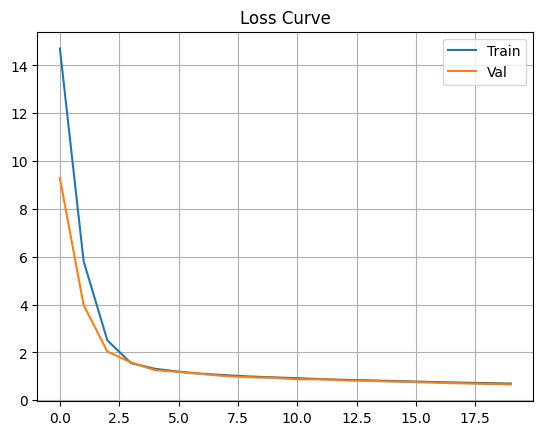

Logs saved to ./training_logs/u2netp_finetune_ir_d5_20250512_011730
Best checkpoint: ./training_logs/u2netp_finetune_ir_d5_20250512_011730/best_model.pth


In [29]:
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/val"
]
mask_dirs  = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/val"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(16,8,8)
)

optimizer = optim.Adam(model_1ch.parameters(), lr=1e-4)
best_ckpt = train_model(
    model_1ch, train_loader, val_loader,
    optimizer,
    scheduler=None,
    num_epochs=20,
    log_prefix="u2netp_finetune_ir_d5",
    device=device
)

print("Best checkpoint:", best_ckpt)


#### Evaluate

In [30]:
# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)


=== Evaluation Results ===
MAE            : 0.0394
Precision      : 0.5633
Recall         : 0.3165
Fβ (β²=0.3): 0.4774
Mean IoU       : 0.2440
Obj Presence R : 0.8460
Binarize thres.: 0.50
Area fraction  : 0.001000


###  6 - IR combined dataset

#### Load model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "u2netp"

# 1) Instantiate a 1‐channel model
model_1ch = U2NETP(1, 1).to(device)

# 2) Load original 3‐channel checkpoint
orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",
                        map_location=device)

# 3) Build a new state dict
new_state = {}
for name, param in orig_state.items():
    # target shape in the 1ch model (if it exists)
    if name in model_1ch.state_dict():
        tgt = model_1ch.state_dict()[name]
        # mismatch only in the in_channels dimension?
        if param.shape != tgt.shape:
            # param is weight with shape [out_c, in_c=3, k, k]
            # tgt is [out_c, in_c=1, k, k]
            if len(param.shape) == 4 and param.shape[1] == 3 and tgt.shape[1] == 1:
                # average across the original in_channels dim
                averaged = param.mean(dim=1, keepdim=True)
                new_state[name] = averaged
                print(f"Averaged '{name}' from {param.shape} → {averaged.shape}")
            else:
                # unexpected mismatch—skip or you can raise
                print(f"Skipping '{name}' due to unexpected shape {param.shape} → {tgt.shape}")
        else:
            # shapes match exactly—copy over
            new_state[name] = param
    else:
        # parameter not used by new model (unlikely)
        print(f"Parameter '{name}' not found in new model—skipping")

# 4) Load into model (strict=False so any missing keys are ignored)
model_1ch.load_state_dict(new_state, strict=False)
model_1ch.eval()

# 5) Check summary
from torchsummary import summary
print("Single‐channel U2NETP summary:")
summary(model_1ch, input_size=(1, 320, 320), device=str(device))


/tmp/ipykernel_1761936/1906240996.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orig_state = torch.load(f"saved_models/{MODEL_NAME}/{MODEL_NAME}.pth",


Averaged 'stage1.rebnconvin.conv_s1.weight' from torch.Size([64, 3, 3, 3]) → torch.Size([64, 1, 3, 3])
Single‐channel U2NETP summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]             640
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1,

/home/deepaksr/project/Project_files_2/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


#### Finetune

Total: 31566 | Train: 22096, Val: 4735, Test: 4735
[1/20] LR:1.0e-04 Train:2.6111 Val:0.7122
Saved best model: ./training_logs/u2netp_finetune_ir_d6_combined_20250514_205349/best_model.pth
[2/20] LR:1.0e-04 Train:0.6189 Val:0.5169
Saved best model: ./training_logs/u2netp_finetune_ir_d6_combined_20250514_205349/best_model.pth
[3/20] LR:1.0e-04 Train:0.4796 Val:0.4314
Saved best model: ./training_logs/u2netp_finetune_ir_d6_combined_20250514_205349/best_model.pth
[4/20] LR:1.0e-04 Train:0.4059 Val:0.3692
Saved best model: ./training_logs/u2netp_finetune_ir_d6_combined_20250514_205349/best_model.pth
[5/20] LR:1.0e-04 Train:0.3603 Val:0.3346
Saved best model: ./training_logs/u2netp_finetune_ir_d6_combined_20250514_205349/best_model.pth
[6/20] LR:1.0e-04 Train:0.3267 Val:0.3013
Saved best model: ./training_logs/u2netp_finetune_ir_d6_combined_20250514_205349/best_model.pth
[7/20] LR:1.0e-04 Train:0.3025 Val:0.2938
Saved best model: ./training_logs/u2netp_finetune_ir_d6_combined_20250514_20534

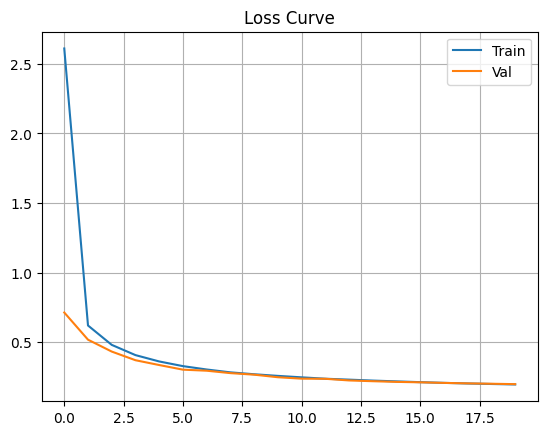

Logs saved to ./training_logs/u2netp_finetune_ir_d6_combined_20250514_205349
Best checkpoint: ./training_logs/u2netp_finetune_ir_d6_combined_20250514_205349/best_model.pth


In [11]:
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/val",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/images",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/images",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/IR_norm8bit",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/norm_ir_8bit"
]
mask_dirs  = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/val",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/IR",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(16,8,8)
)

optimizer = optim.Adam(model_1ch.parameters(), lr=1e-4)
best_ckpt = train_model(
    model_1ch, train_loader, val_loader,
    optimizer,
    scheduler=None,
    num_epochs=20,
    log_prefix="u2netp_finetune_ir_d6_combined",
    device=device
)

print("Best checkpoint:", best_ckpt)


#### Evaluate

In [12]:
# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model_1ch,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)


=== Evaluation Results ===
MAE            : 0.0125
Precision      : 0.8021
Recall         : 0.7312
Fβ (β²=0.3): 0.7845
Mean IoU       : 0.6615
Obj Presence R : 0.9454
Binarize thres.: 0.50
Area fraction  : 0.001000
